In [1]:
import pyscf
from pyscf import lo
import Driver_SCF
import get_atom_orb
import Util_Mole
from functools import reduce
import numpy
import Chem_Bond_Analysis
from Chem_Bond_Analysis import generate_atm_bas_given_label,occ_label,vir_label
import seaborn,pandas
import matplotlib.pyplot as plt
import Util_Math
import torch
import Util_Pic

/home/ningzhang/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def _analysis_error(data):
    etot = []
    eocc = []
    evir = []

    for _data in data:
        etot_tmp = _data["etot"]
        eocc_tmp = _data["occ"]
        evir_tmp = _data["occvir"]
        etot.append(etot_tmp)
        eocc.append(eocc_tmp-etot_tmp)
        evir.append(evir_tmp-etot_tmp)

    plt.figure(figsize=(16, 9))
    plt.scatter(etot, eocc)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.scatter(etot, evir)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.hist(eocc)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.hist(evir)
    plt.show()


In [17]:
basis = ["6-31G(d)", "ccpvdz", "ccpvtz", "ccpvqz", "aug-ccpvdz"]
vir = ["large", "minimal"]

for basis_ in basis:
    for vir_ in vir:
        filename = "loc_mo_analysis_" + basis_ + "_" + vir_ + ".data"
        data = torch.load(filename)
        print("******************* %s %s *******************" % (basis_, vir_))
        _analysis_error(data)


******************* 6-31G(d) large *******************


NameError: name '_analysis_error' is not defined

In [2]:
basis = "6-31G(d)"
# basis = "sto-3g"
# basis = "ccpvtz"

atom_bas = get_atom_orb.atom_min_cas_bas(["C","H","O","N"], basis=basis, print_verbose=0)


the energy of HF with input MO is    -37.58827348, with diff  0.00000000e+00
14 14 14


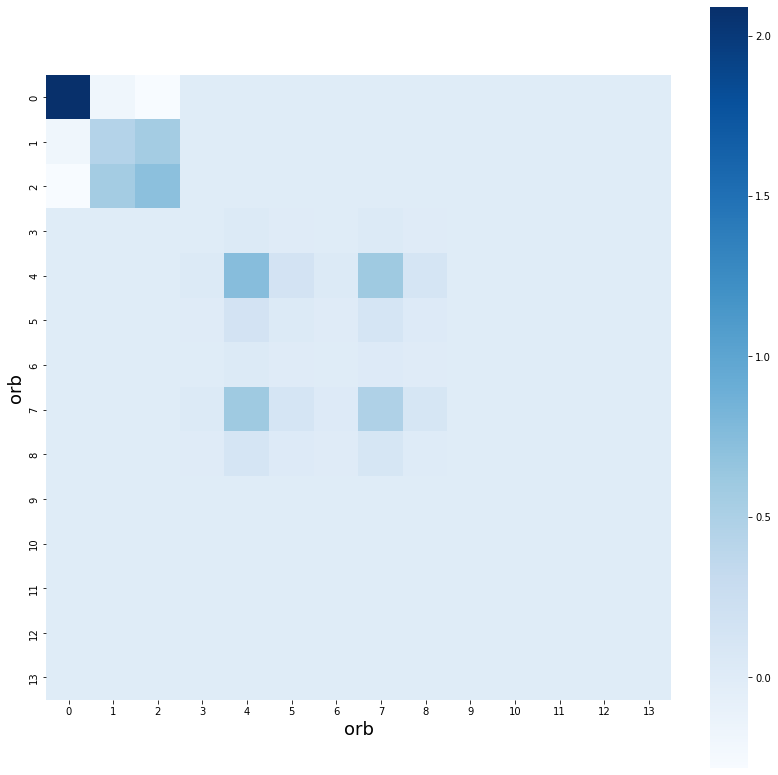

14 14 14


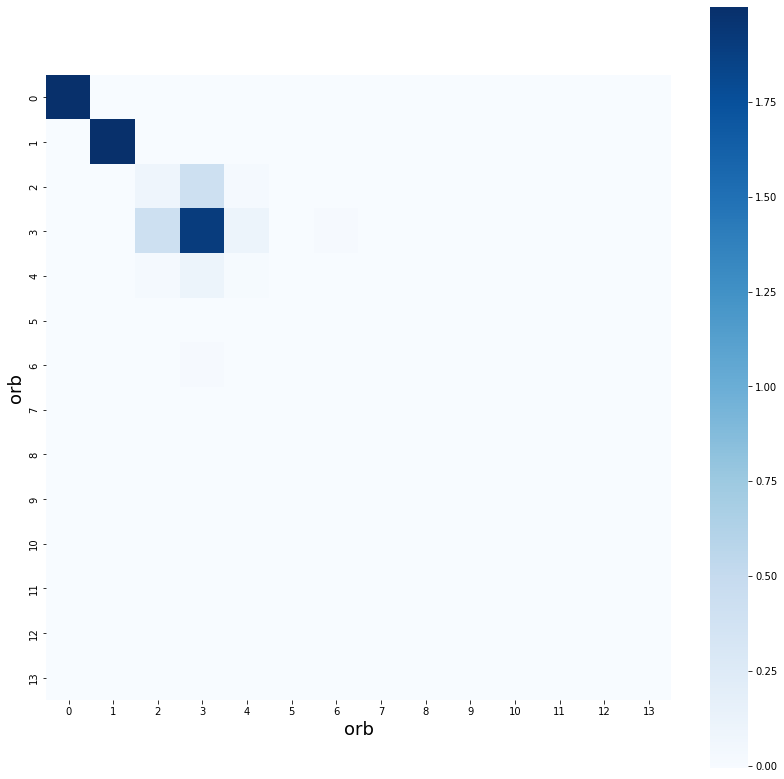

14 14 14


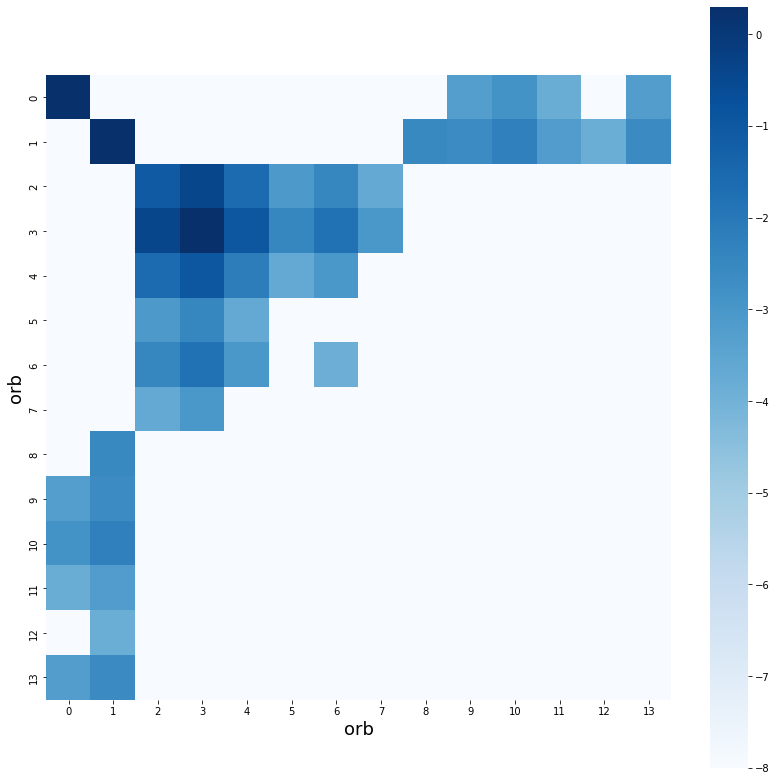

In [3]:
atom_xyz =  '''
C 0 0 0
'''
chem_bond_analyzer = Chem_Bond_Analysis.ChemBondAnalyzer(
    xyz=atom_xyz, print_verbose=0,basis=basis)
chem_bond_analyzer.atom_bas = atom_bas
# chem_bond_analyzer.check_cnvg_orb_proj_atm_occ()
chem_bond_analyzer.check_cnvg_orb_proj_atm_occ_vir()

dm = chem_bond_analyzer.dm
Util_Pic.draw_heatmap(dm, None, None, numpy.max(
    dm), numpy.min(dm), x_label="orb", y_label="orb")

dm_mol_atom = chem_bond_analyzer.dm_mole_atom_bas
dm_mol_atom_log = numpy.log10(numpy.abs(dm_mol_atom))
dm_mol_atom_log[dm_mol_atom_log<-4] = -8
Util_Pic.draw_heatmap(dm_mol_atom, None, None, numpy.max(
    dm_mol_atom), numpy.min(dm_mol_atom), x_label="orb", y_label="orb")
Util_Pic.draw_heatmap(dm_mol_atom_log, None, None, numpy.max(
    dm_mol_atom_log), numpy.min(dm_mol_atom_log), x_label="orb", y_label="orb")

In [5]:
mol_xyz = '''
C 0.1687934049 1.5251304224 -0.1574705569
C -0.1873762459 0.0619476271 0.1467937419
C 0.5091764497 -0.4399621499 1.3912584954
O 1.1819107901 -1.4356558471 1.4581638410
H 1.2312651068 1.6313725408 -0.3963269270
H -0.4074466801 1.8943168107 -1.0096924649
H -0.0493103389 2.1726626043 0.6985743244
H -1.2690515996 -0.0166806666 0.3285443317
H 0.0627906152 -0.6025047855 -0.6847403572
H 0.3538484078 0.2066337038 2.2887105216
'''

In [6]:
chem_bond_analyzer = Chem_Bond_Analysis.ChemBondAnalyzer(
    xyz=mol_xyz, print_verbose=0,basis=basis)
chem_bond_analyzer.atom_bas = atom_bas
# chem_bond_analyzer.check_cnvg_orb_proj_atm_occ()
chem_bond_analyzer.check_cnvg_orb_proj_atm_occ_vir()

the energy of HF with input MO is   -191.94829369, with diff -2.27373675e-13


-191.94829369471128

68 68 68


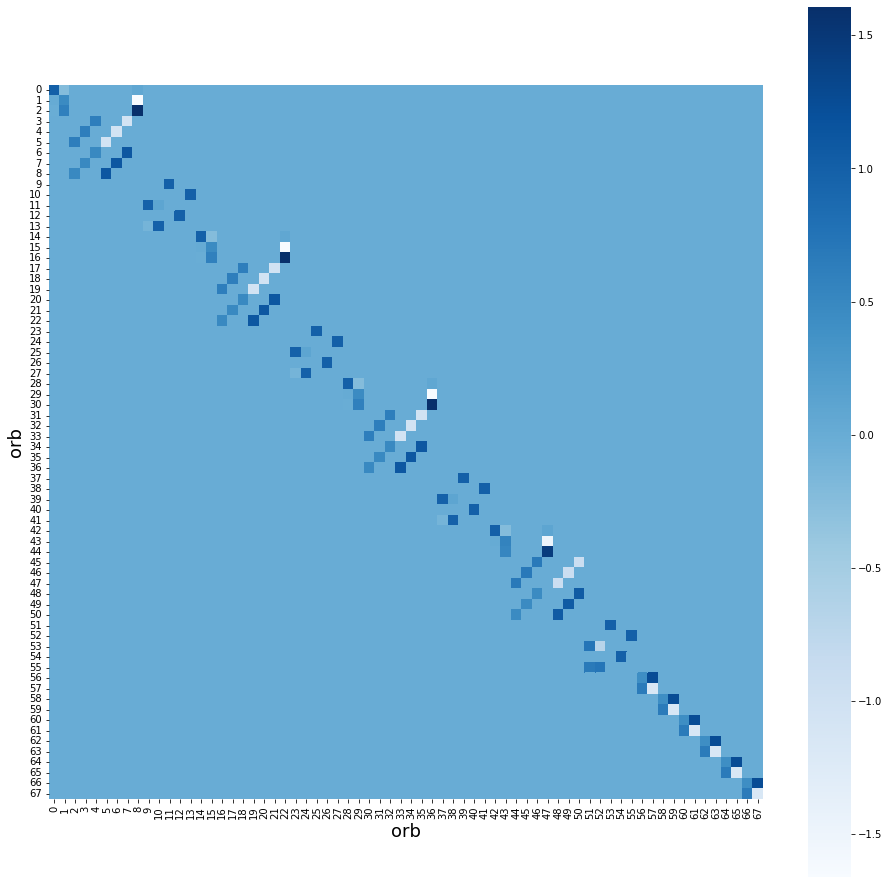

In [18]:
Util_Pic.draw_heatmap(chem_bond_analyzer.mole_atm_bas, None, None, numpy.max(
        chem_bond_analyzer.mole_atm_bas), numpy.min(chem_bond_analyzer.mole_atm_bas), x_label="orb", y_label="orb")

68 68 68


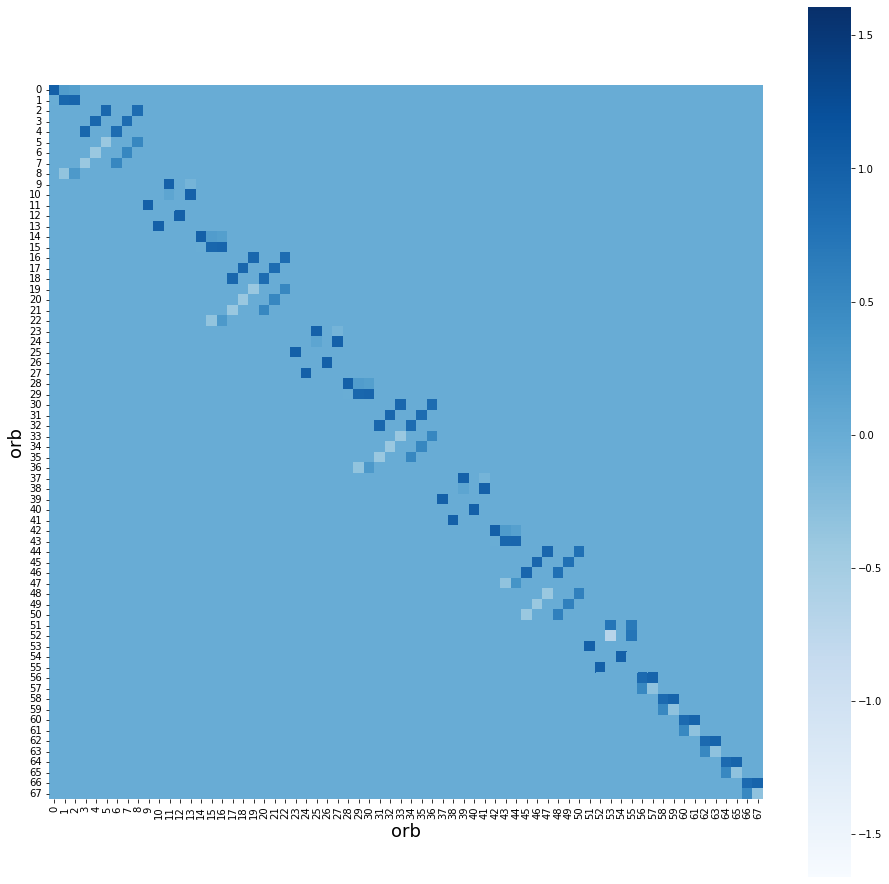

In [19]:
Util_Pic.draw_heatmap(chem_bond_analyzer.mole_atm_bas.I, None, None, numpy.max(
        chem_bond_analyzer.mole_atm_bas), numpy.min(chem_bond_analyzer.mole_atm_bas), x_label="orb", y_label="orb")

In [7]:
chem_bond_analyzer.check_cnvg_orb_proj_atm_occ()
chem_bond_analyzer.e_tot

the energy of HF with input MO is   -191.46061531, with diff  4.87678388e-01


-191.94829369471105

In [9]:
loc_mo = chem_bond_analyzer.loc_mo

In [ ]:
chem_bond_analyzer.mole_atm_bas.I.T

In [ ]:
chem_bond_analyzer.mole_atm_bas.I

68 68 68


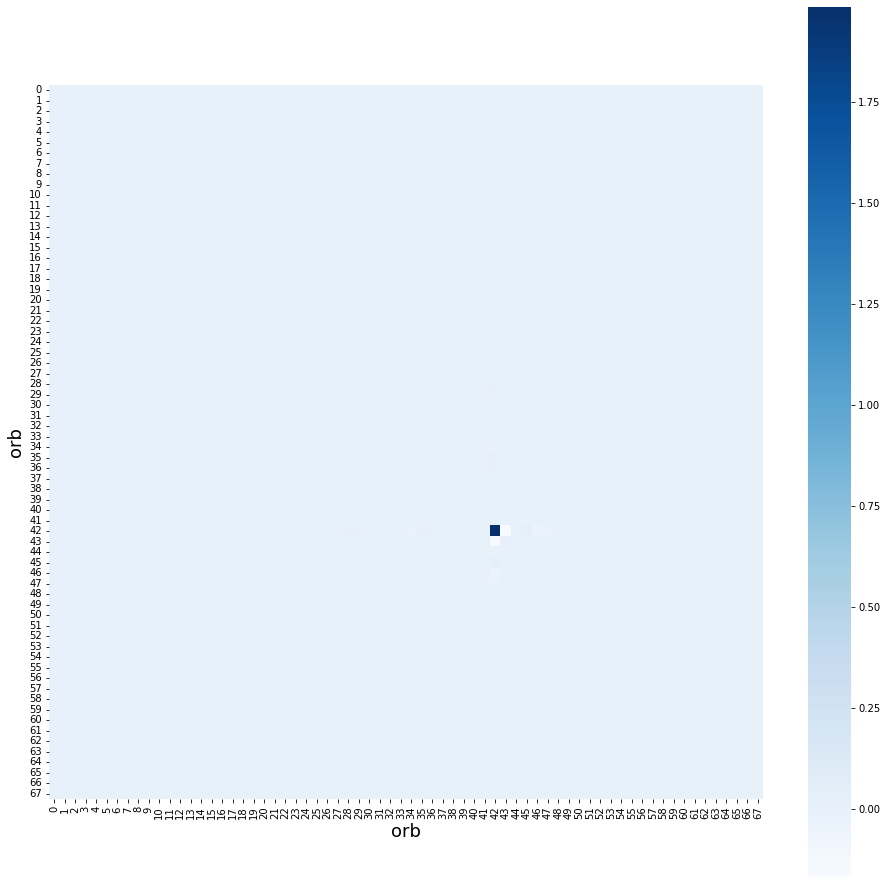

68 68 68


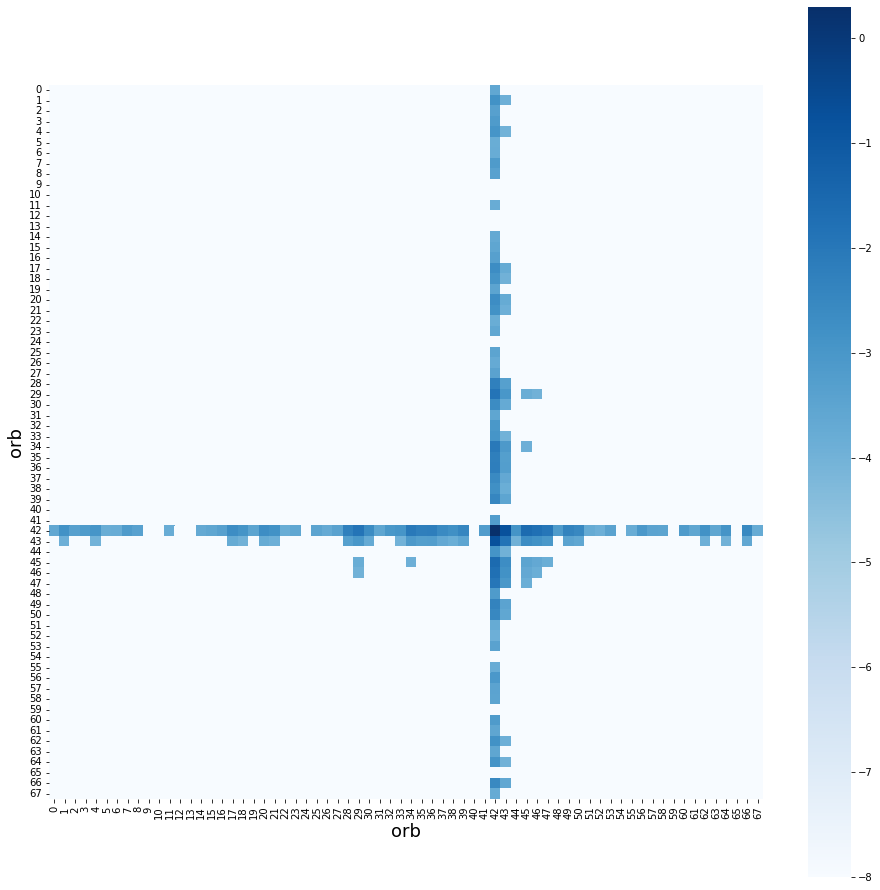

68 68 68


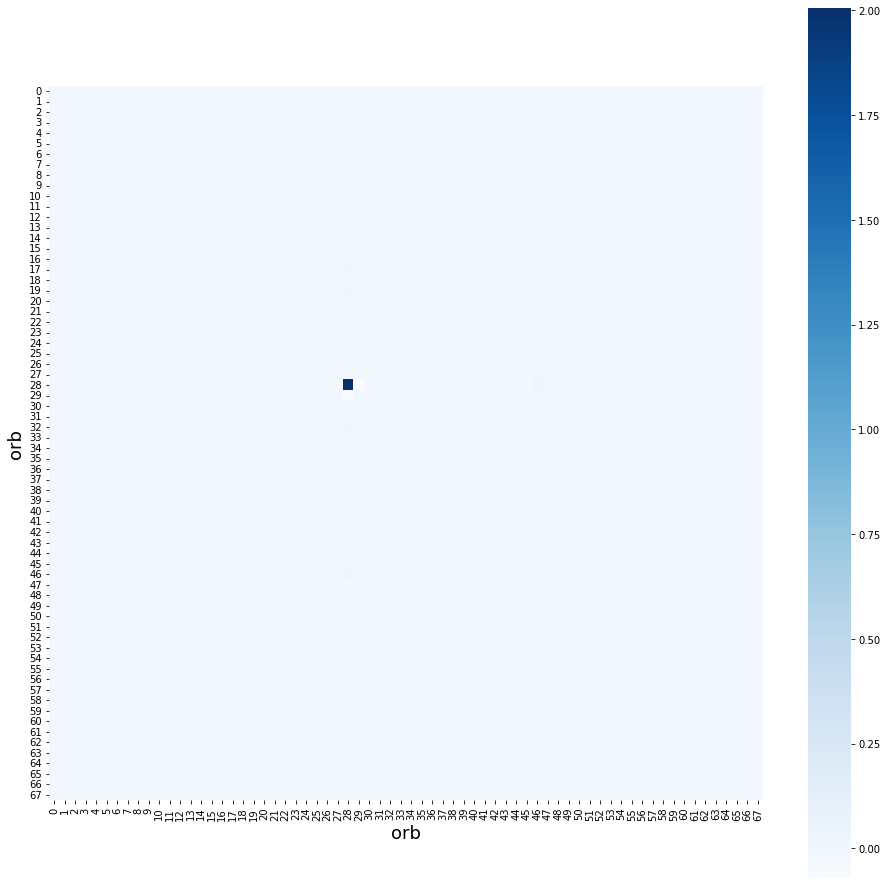

68 68 68


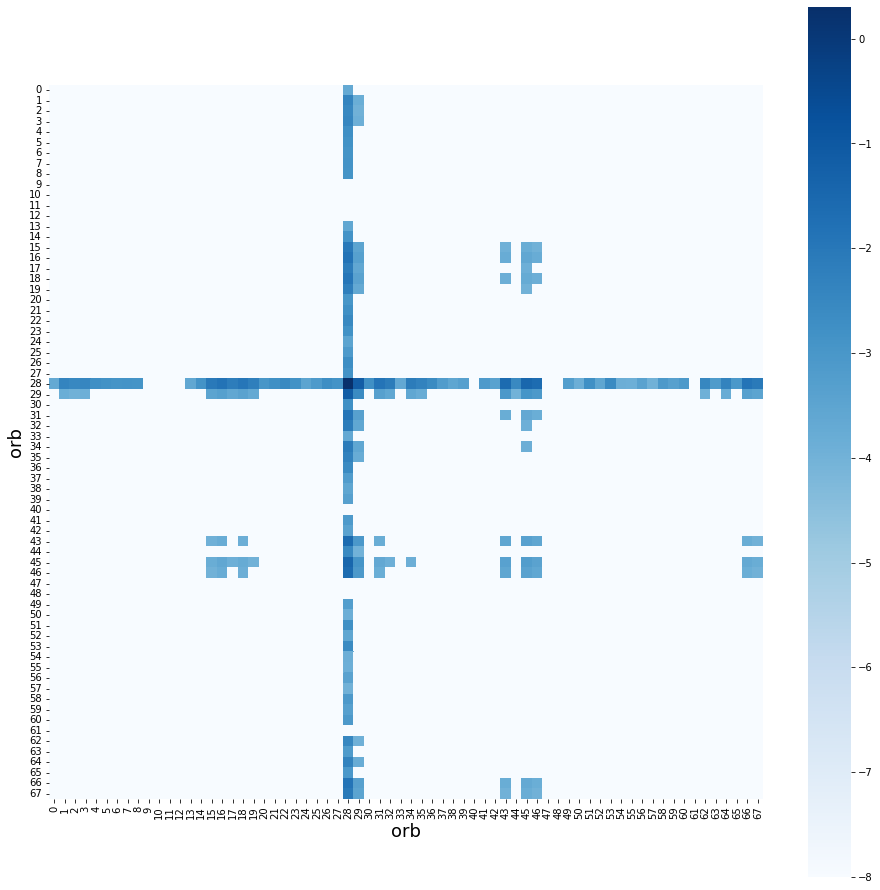

68 68 68


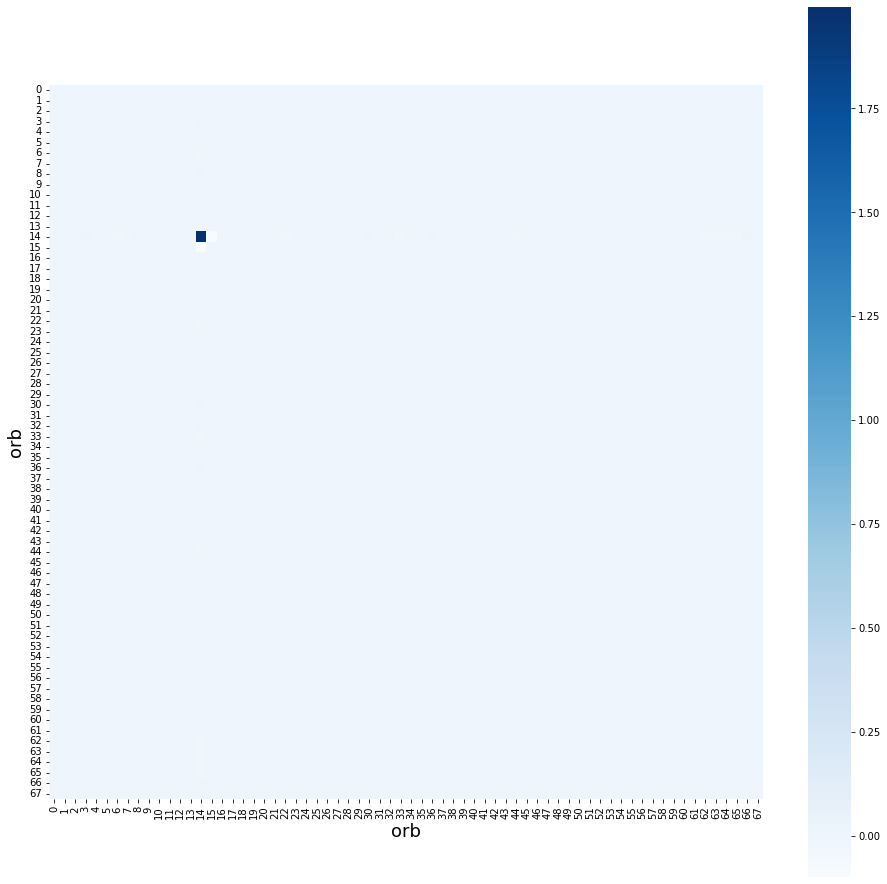

68 68 68


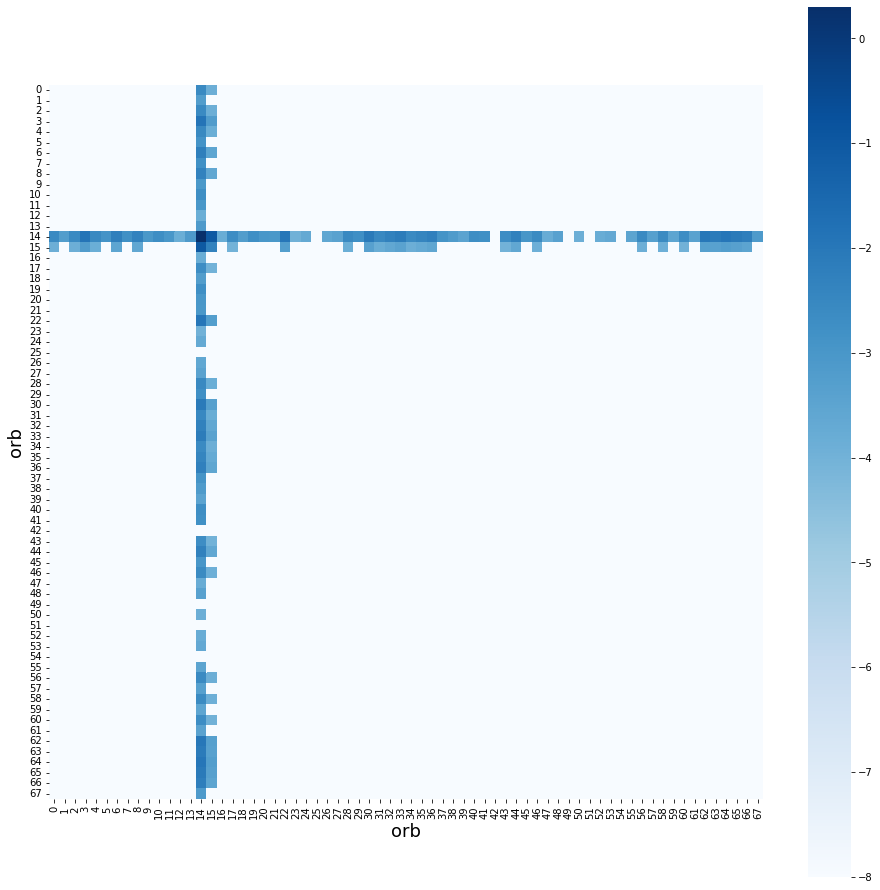

68 68 68


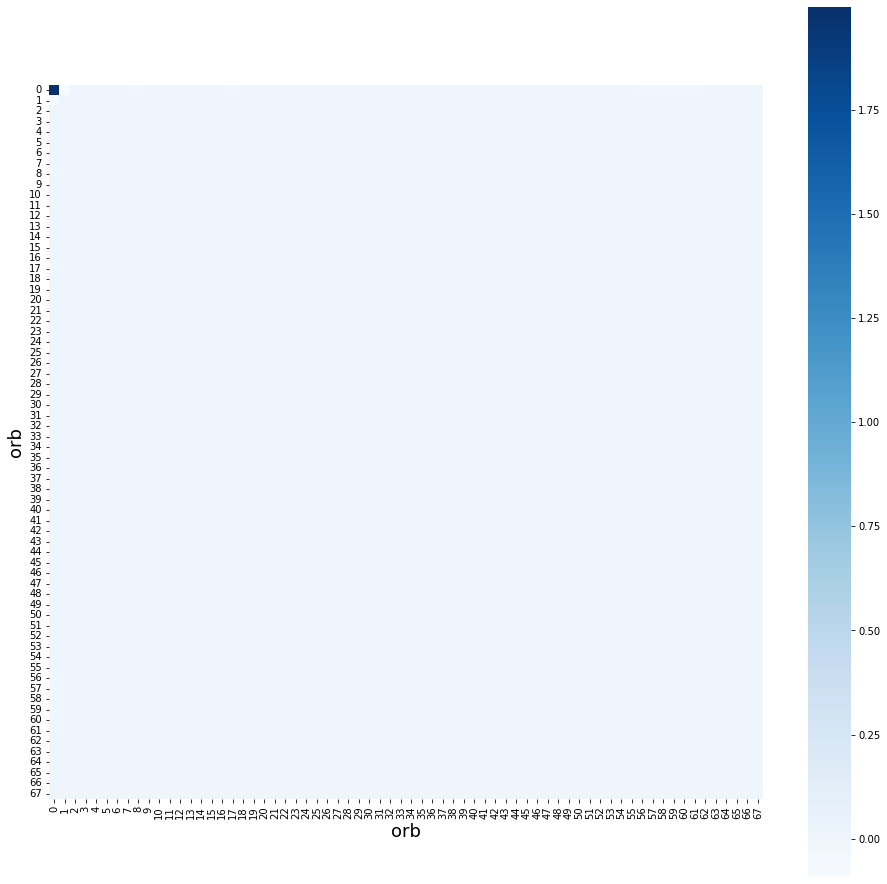

68 68 68


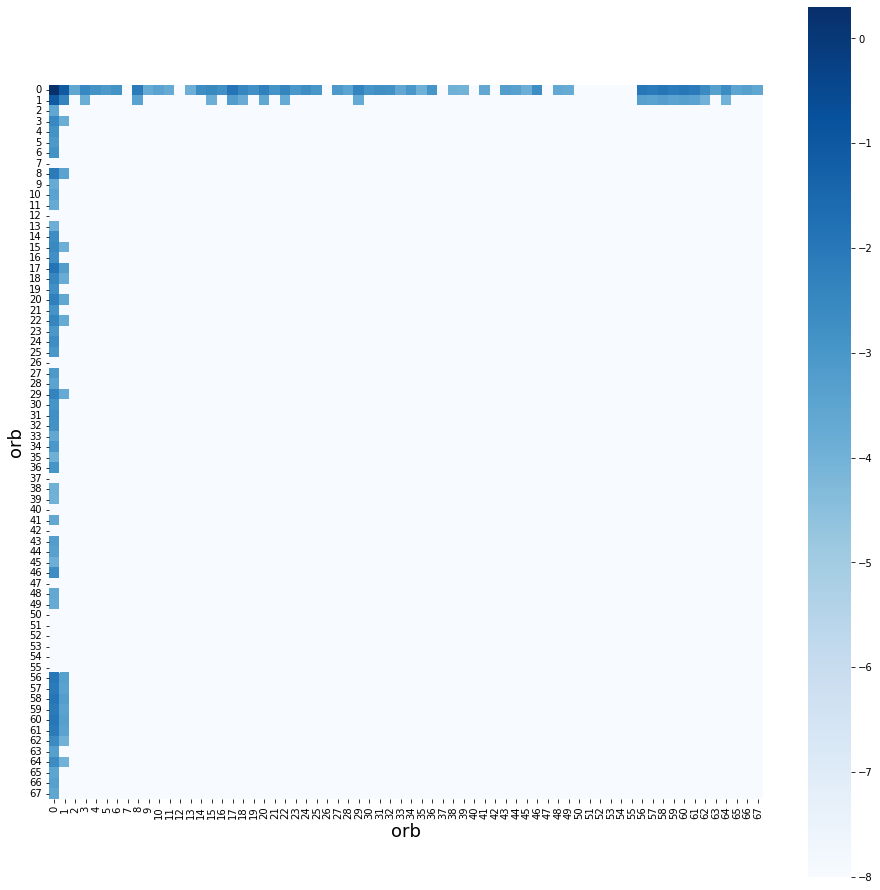

68 68 68


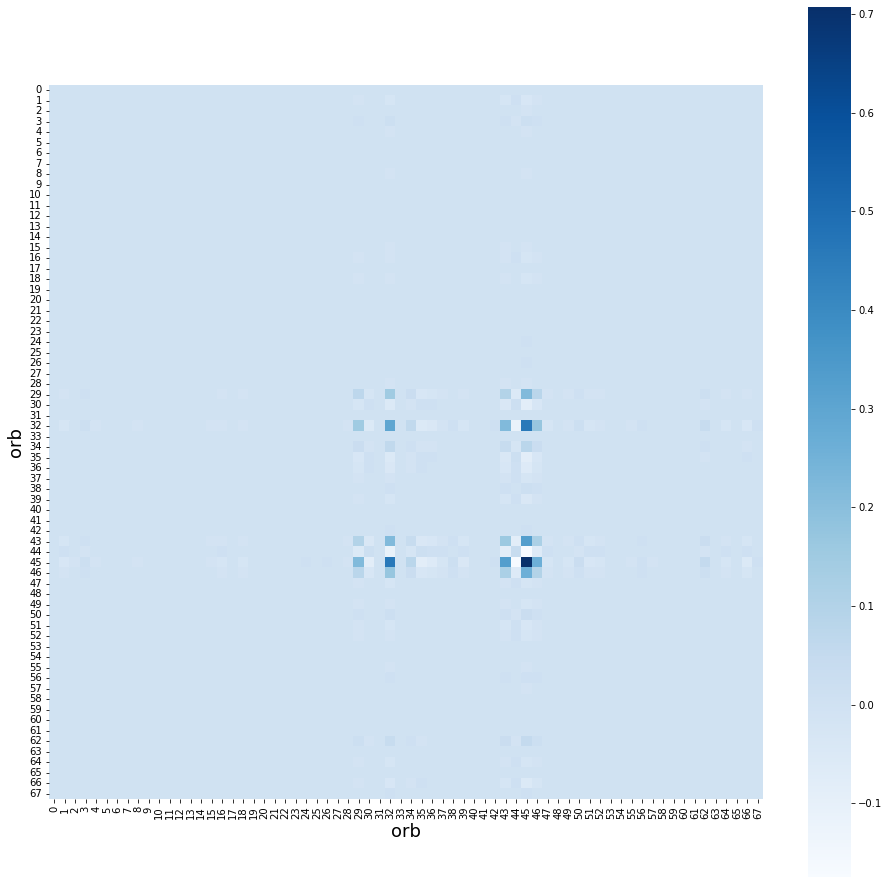

68 68 68


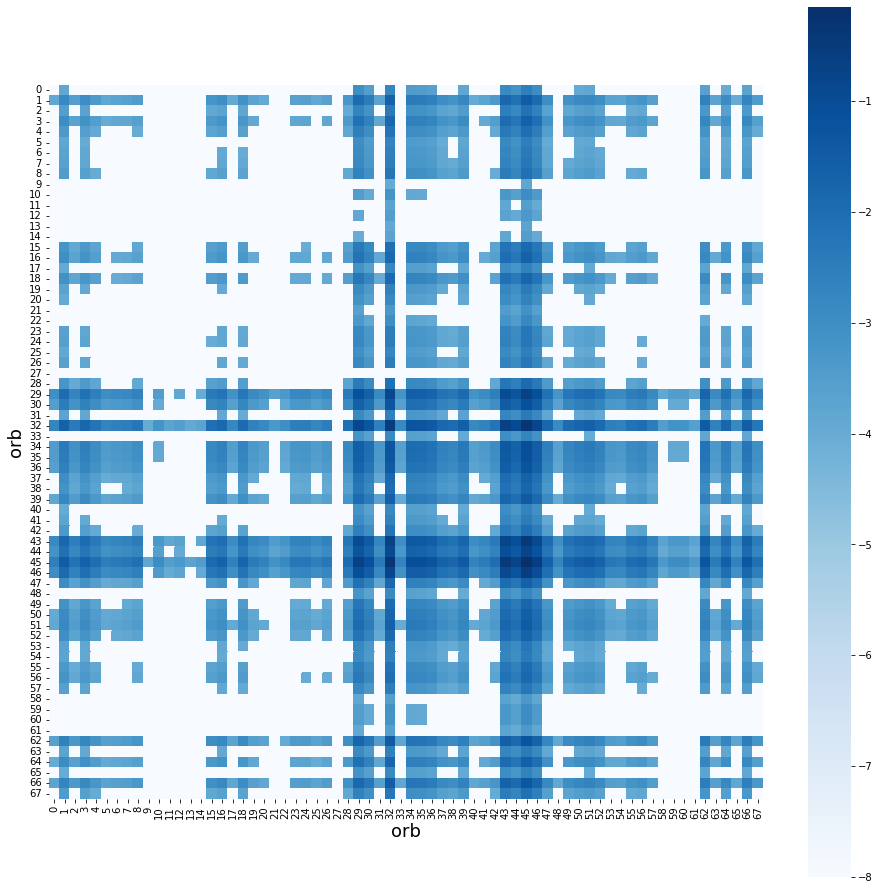

68 68 68


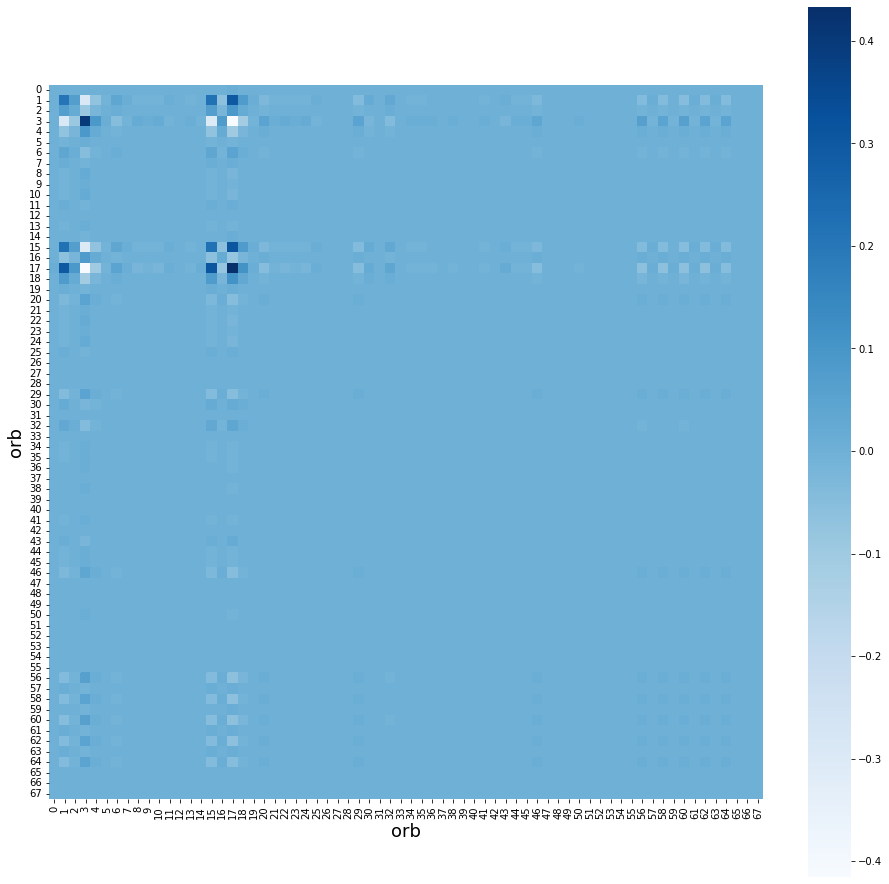

68 68 68


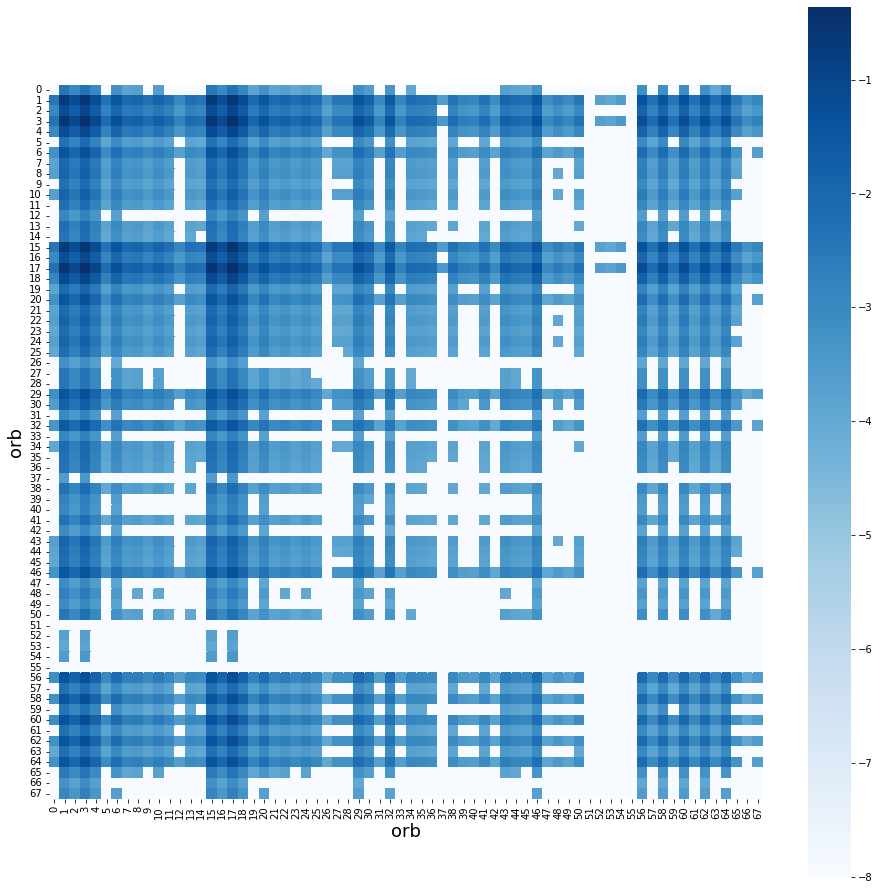

68 68 68


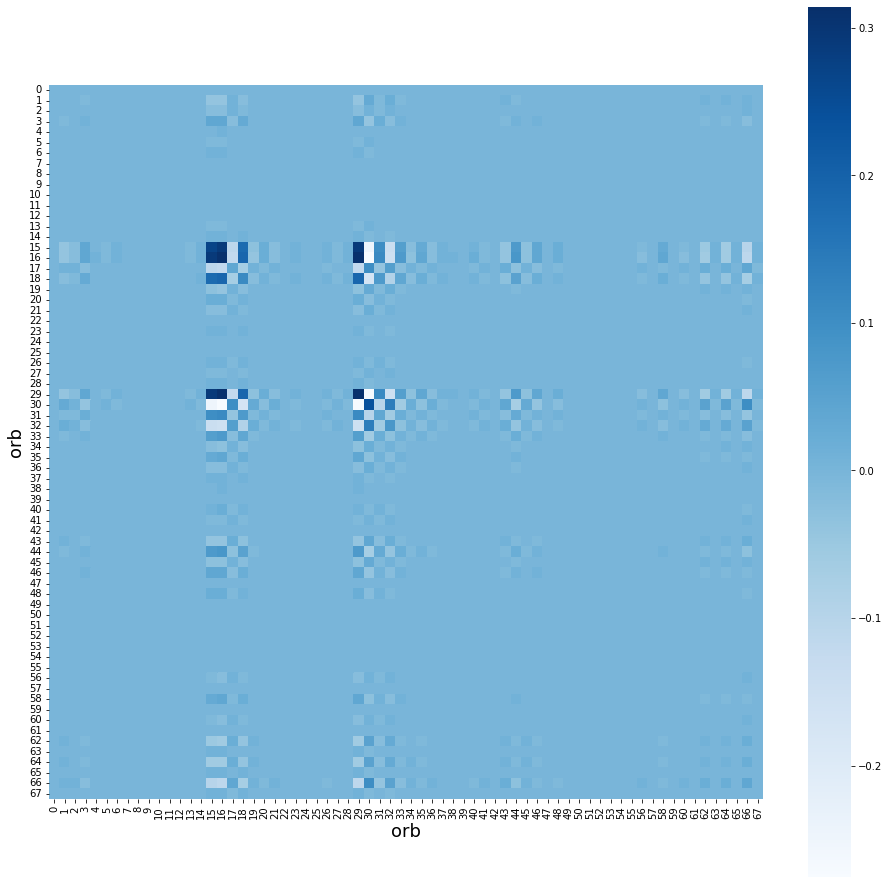

68 68 68


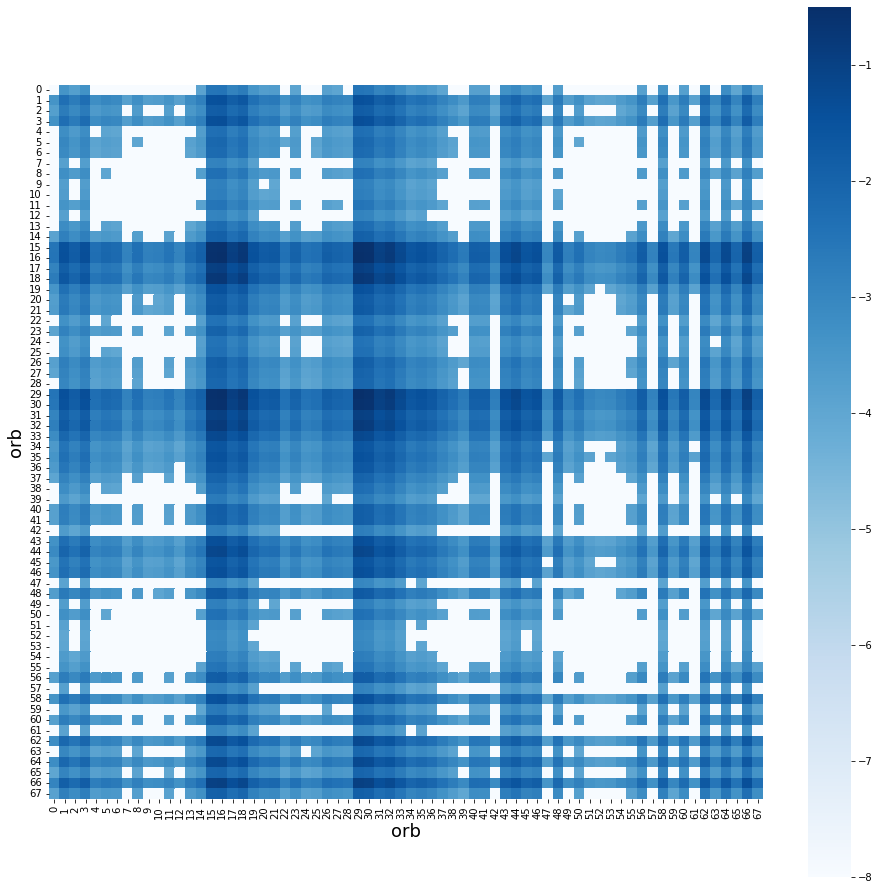

68 68 68


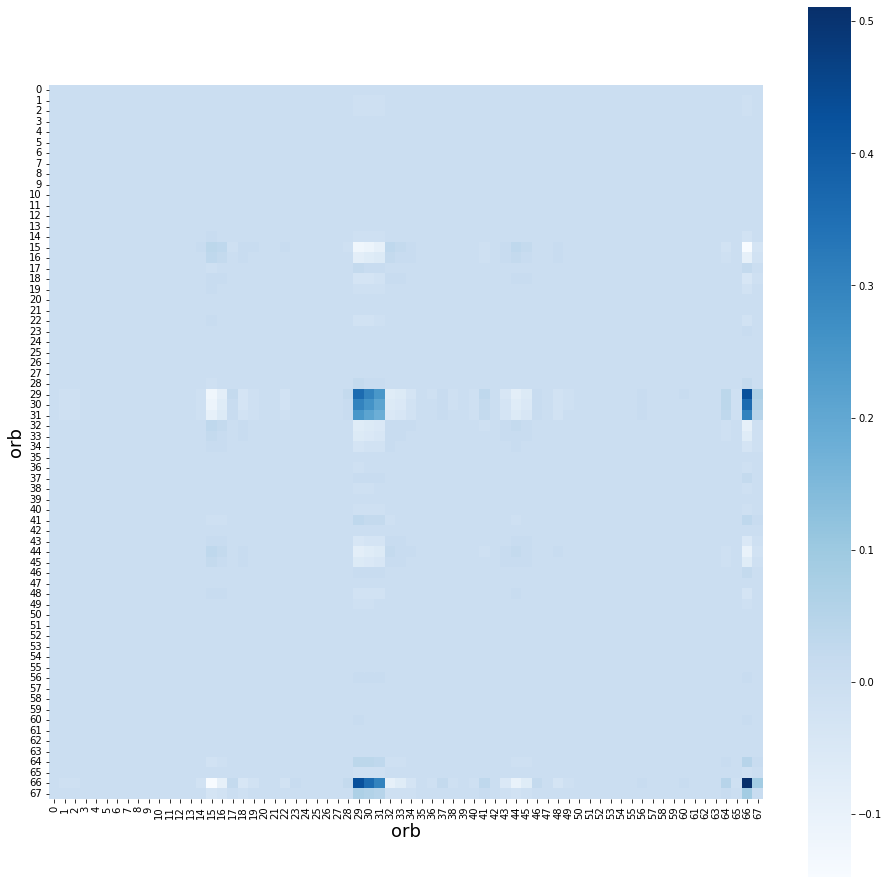

68 68 68


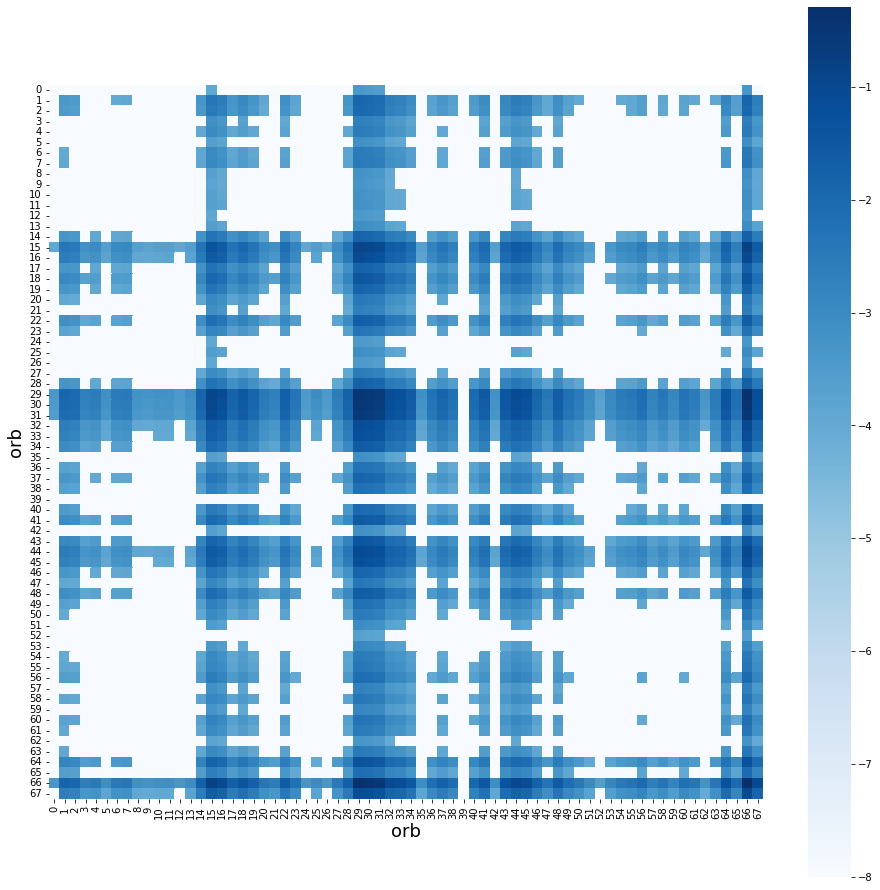

68 68 68


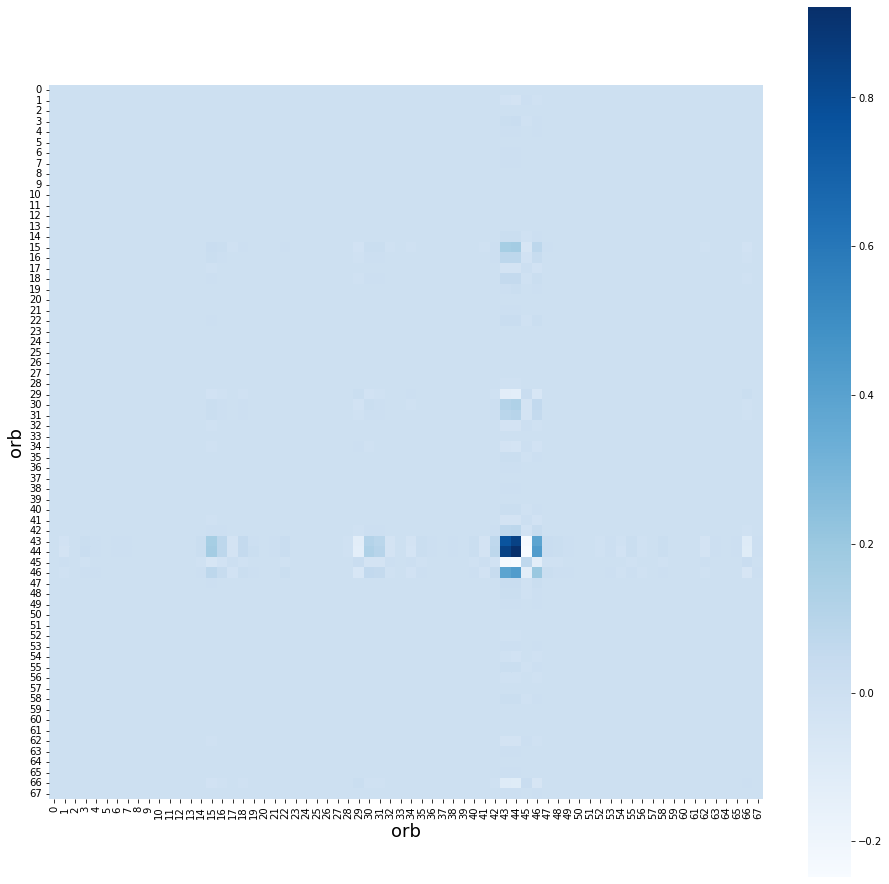

68 68 68


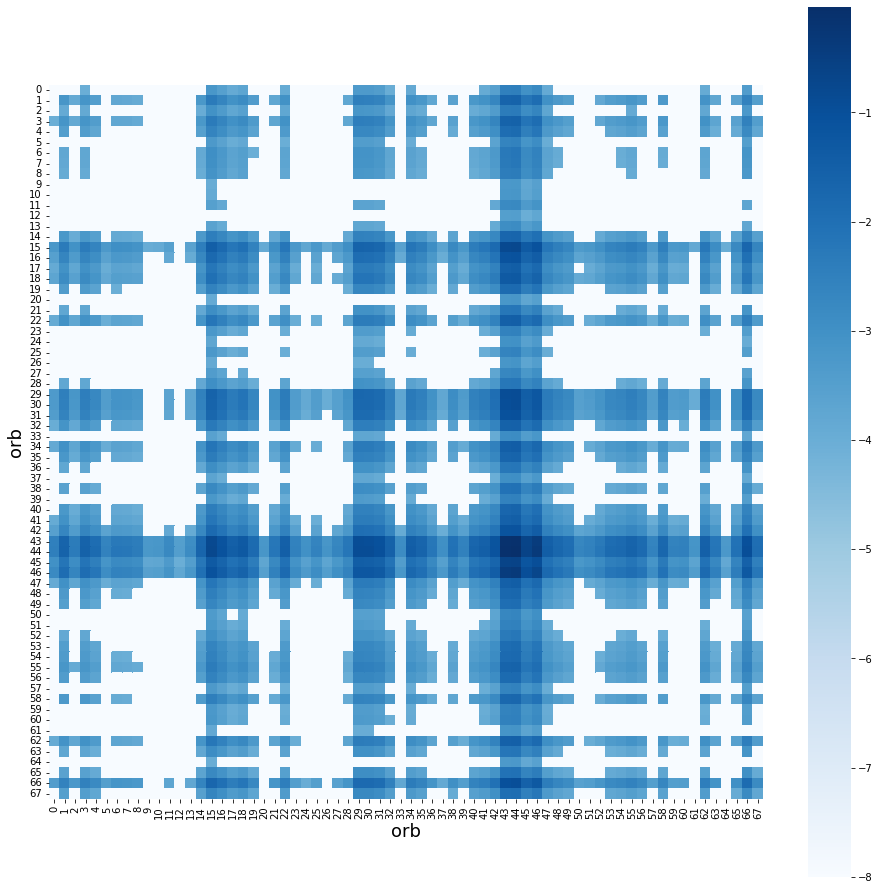

68 68 68


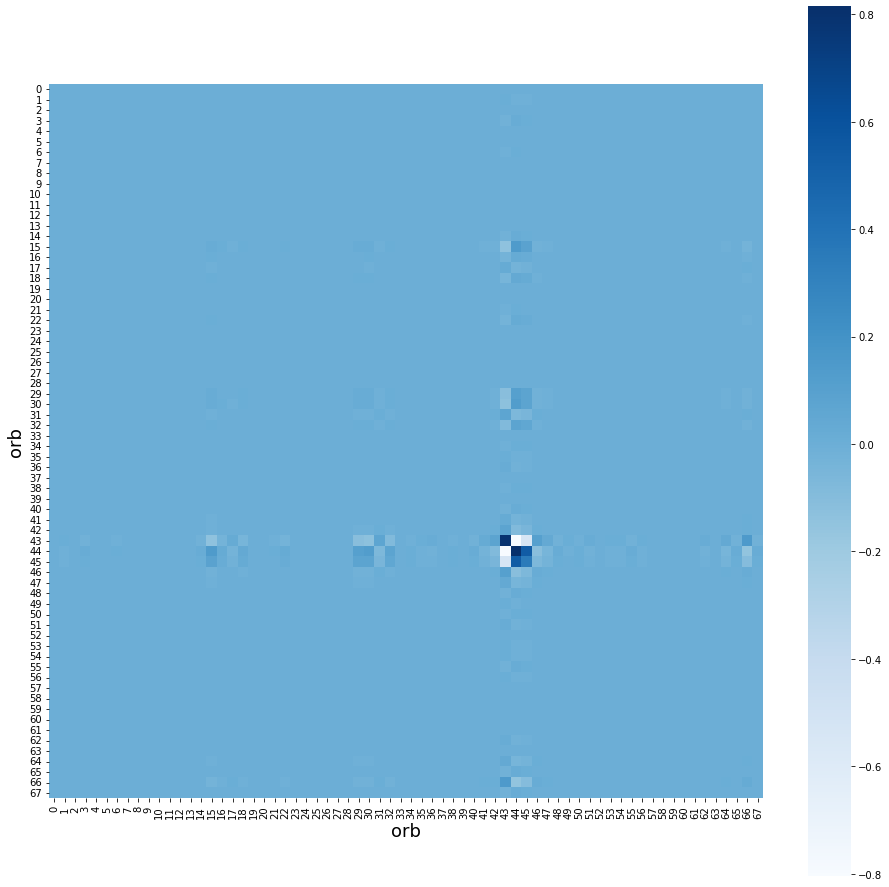

68 68 68


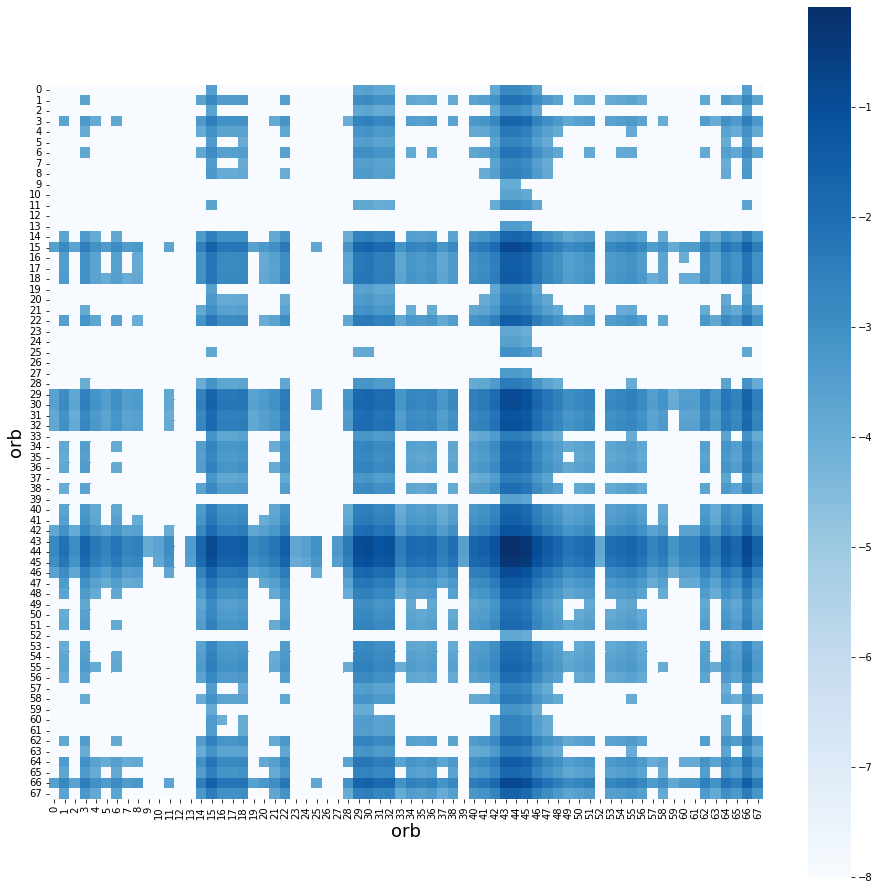

68 68 68


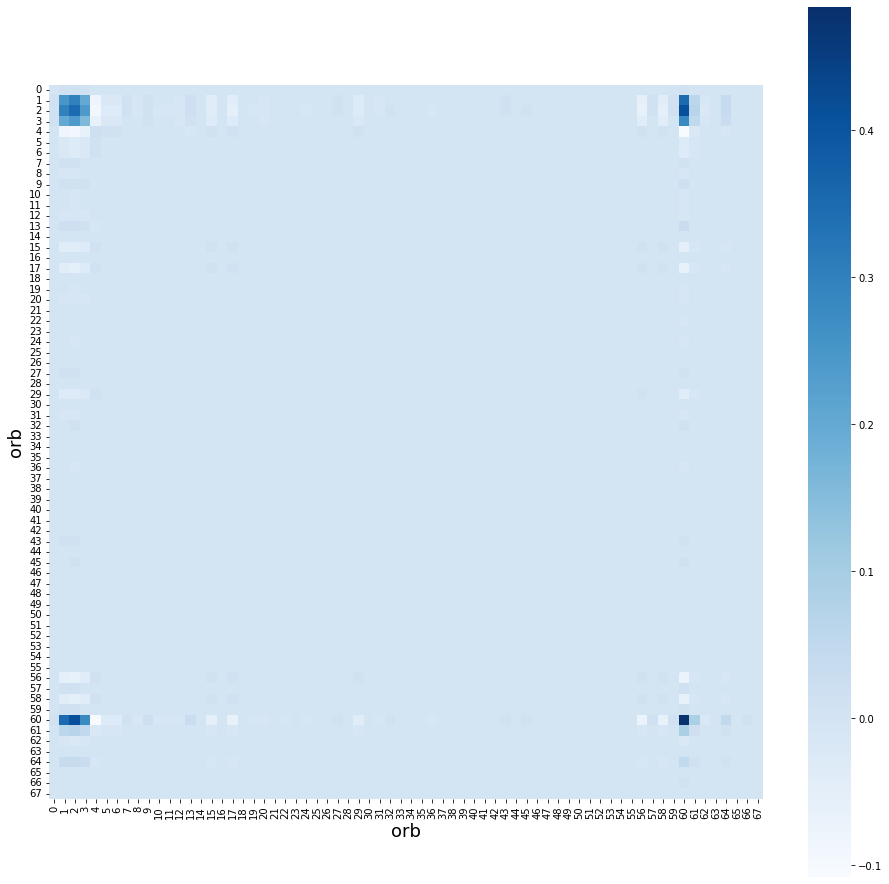

68 68 68


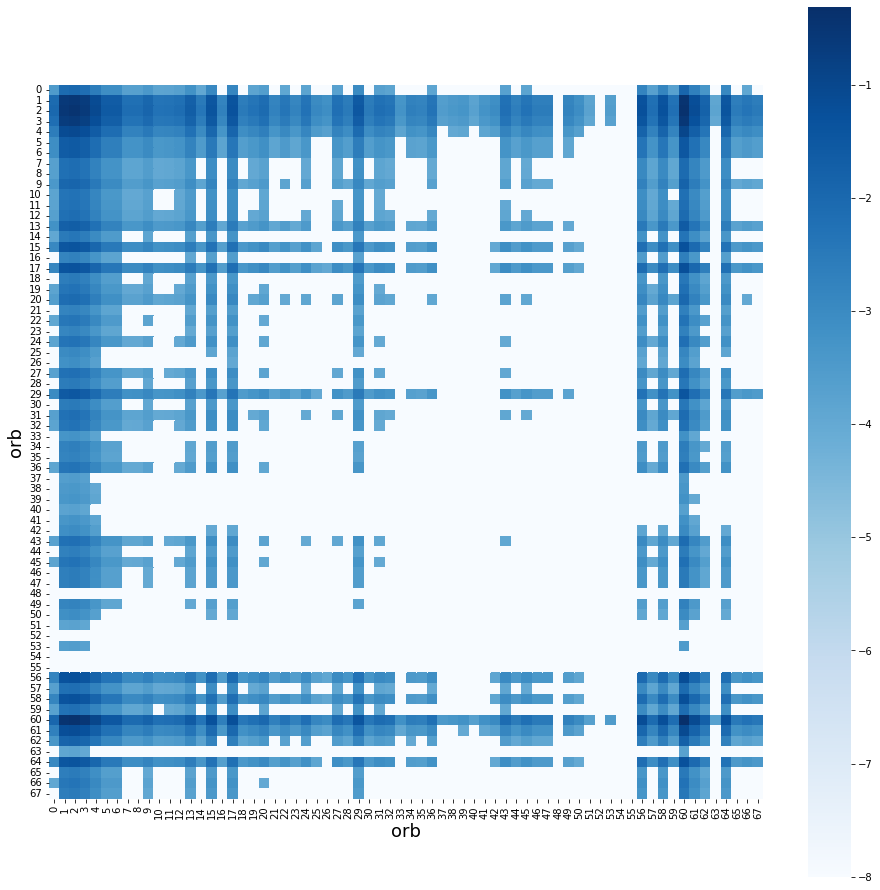

68 68 68


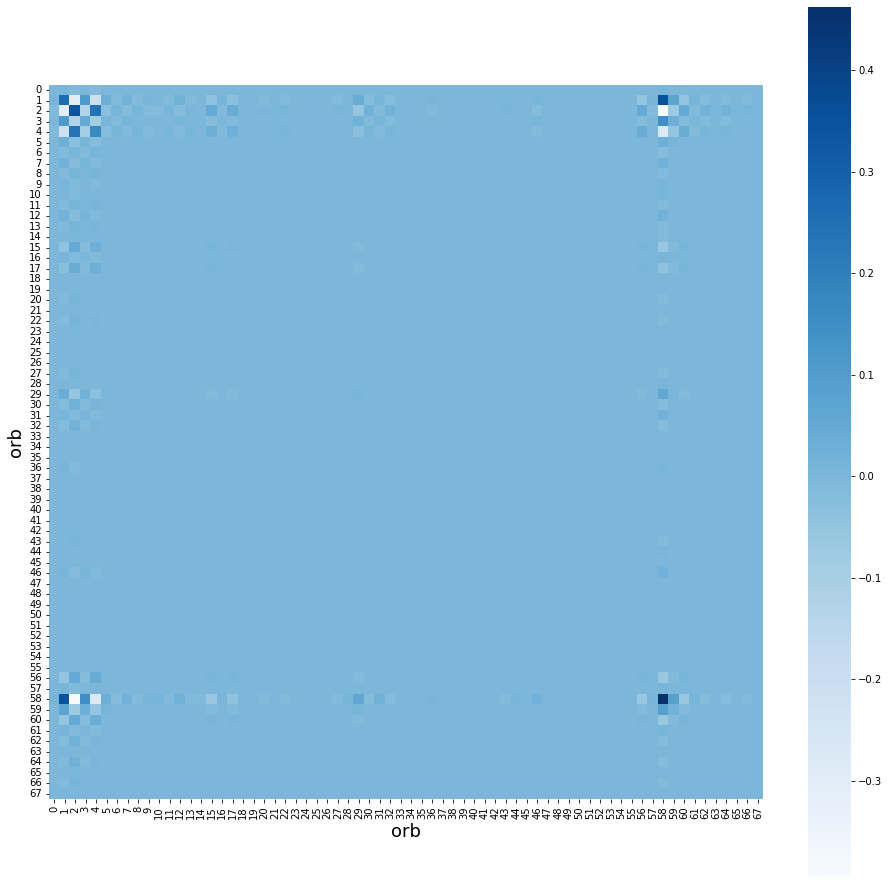

68 68 68


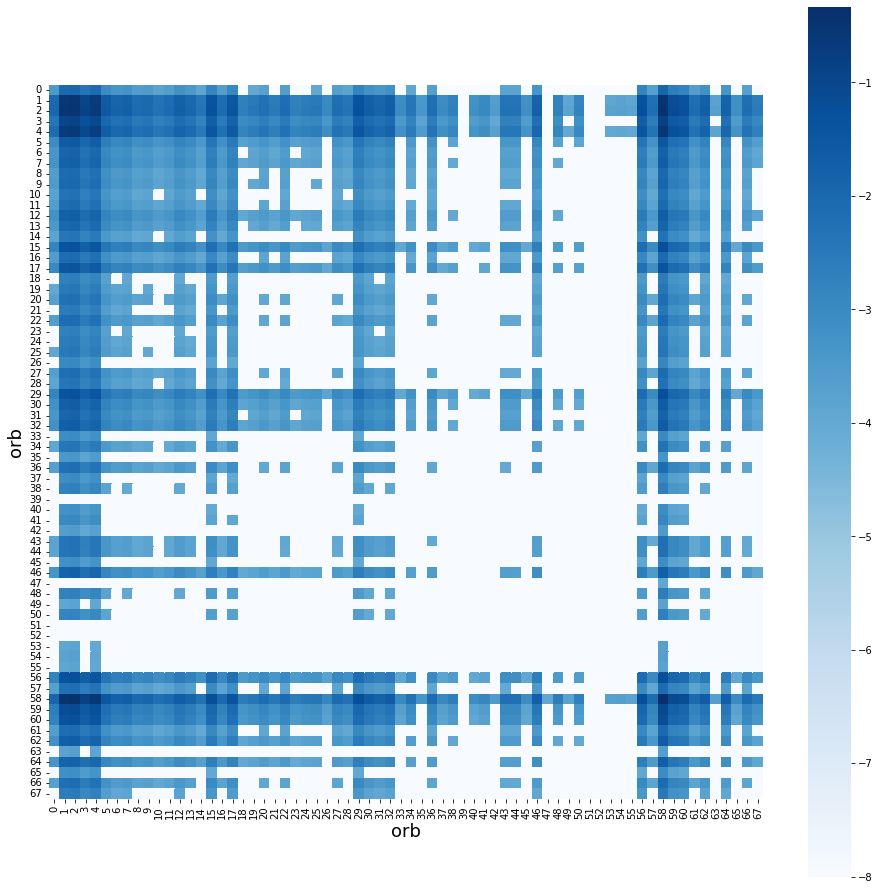

68 68 68


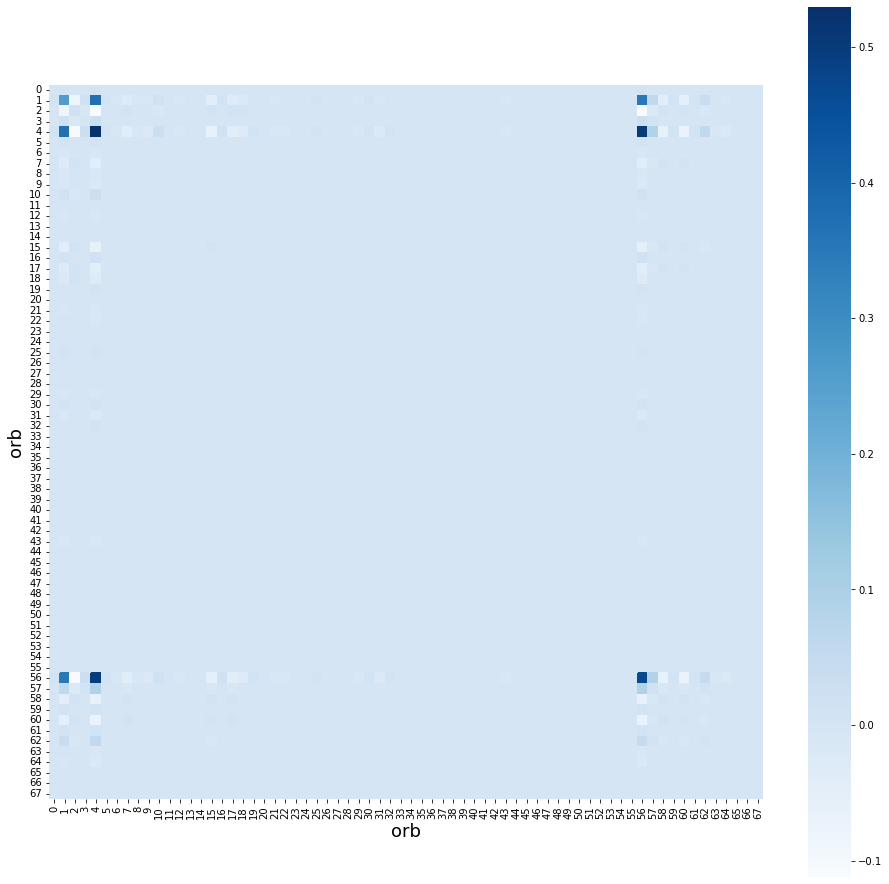

68 68 68


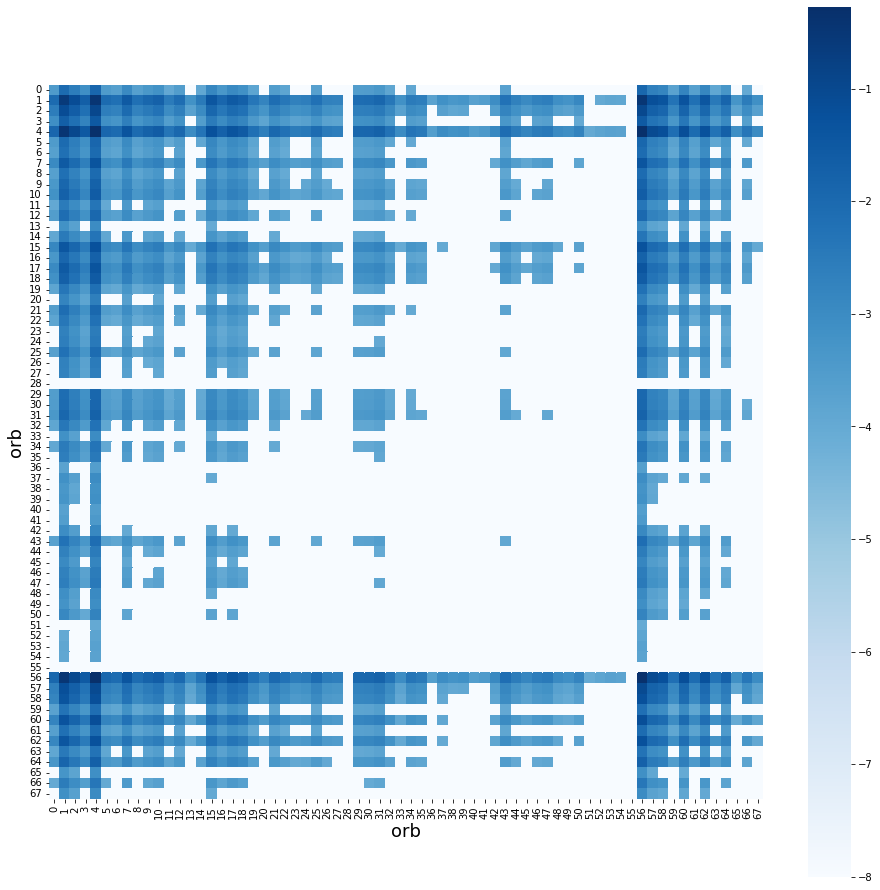

68 68 68


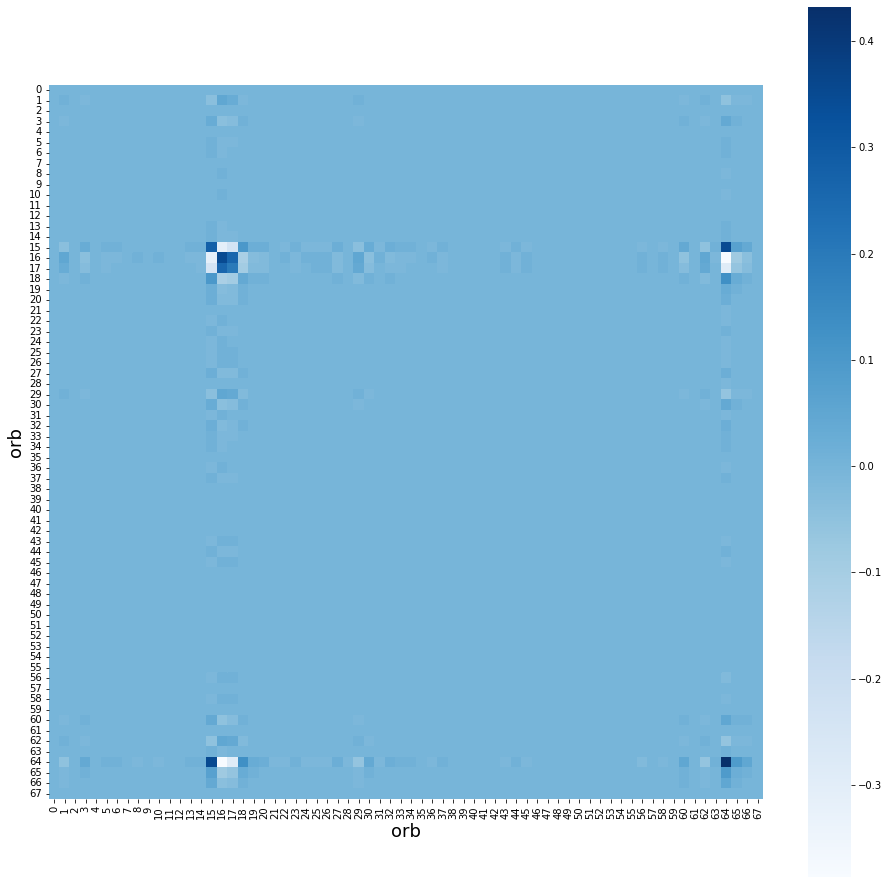

68 68 68


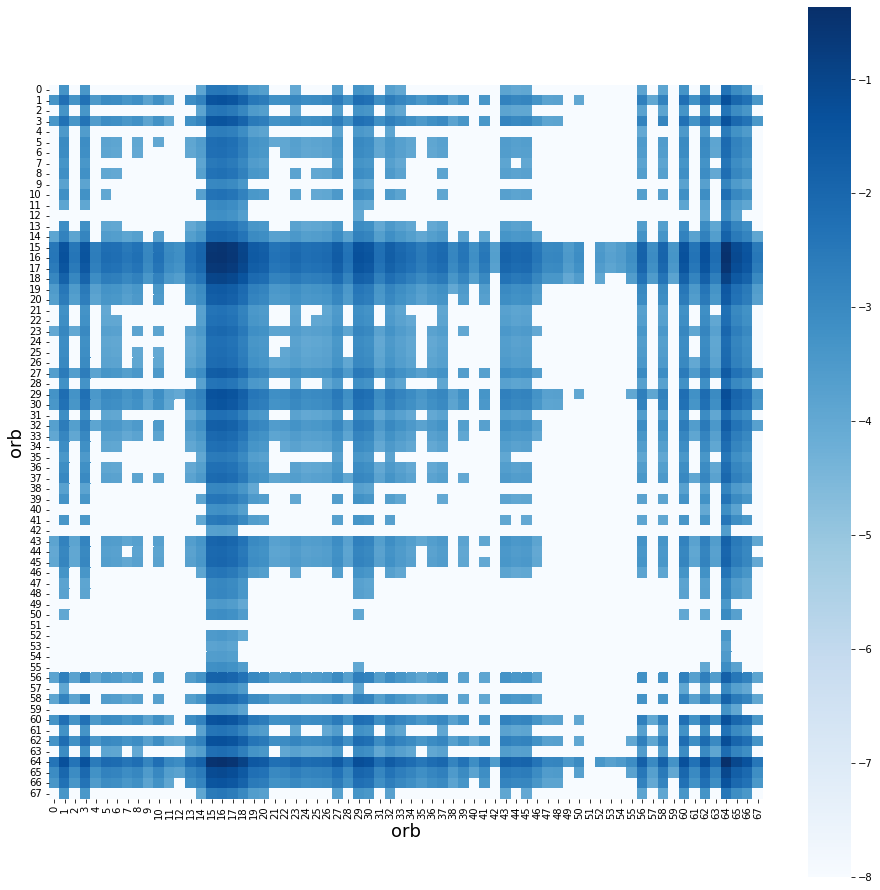

68 68 68


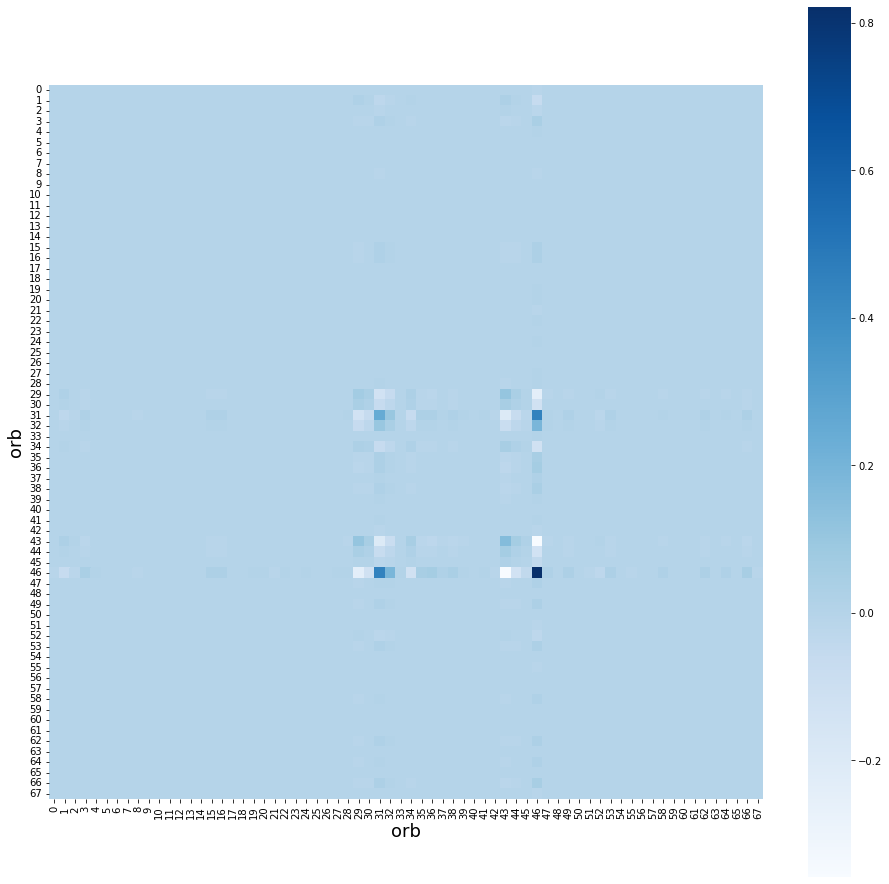

68 68 68


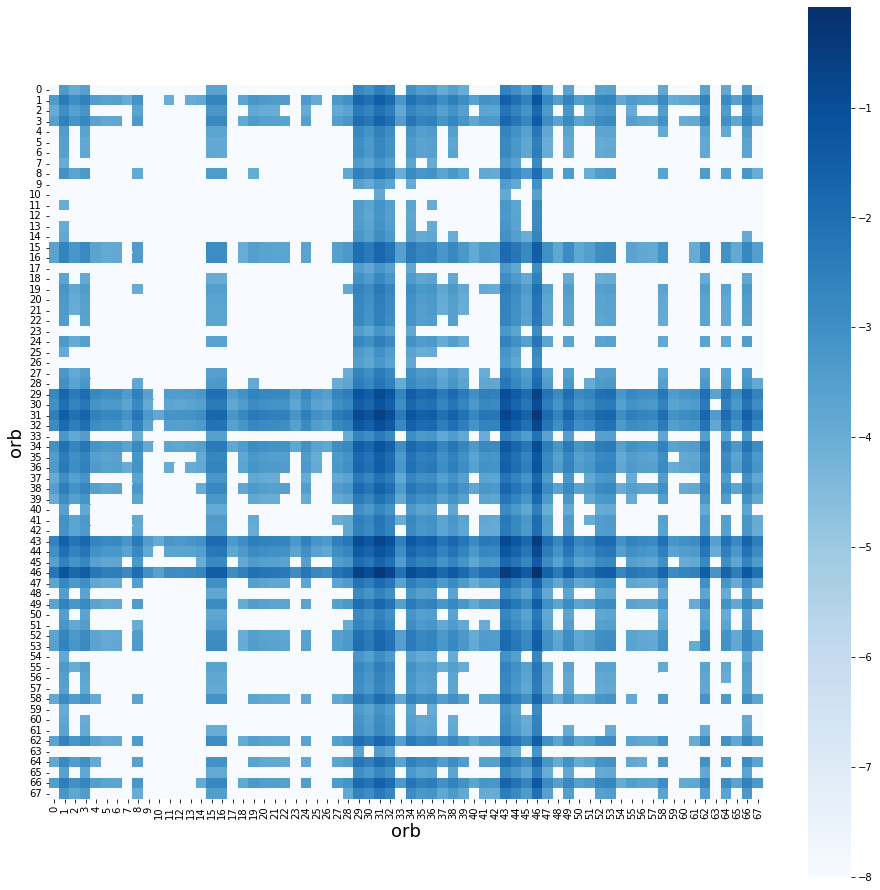

In [11]:
# C-H bond 

for i in range(loc_mo.shape[1]-1):
    dm_2 = numpy.dot(loc_mo[:, i:i+1], loc_mo[:, i:i+1].T) * 2
    dm_2 = reduce(numpy.dot, (chem_bond_analyzer.mole_atm_bas.I,
                  dm_2, chem_bond_analyzer.mole_atm_bas.I.T))
    # print(dm_2)
    dm_2_log = numpy.log10(numpy.abs(dm_2))
    dm_2_log[dm_2_log < -4] = -8
    Util_Pic.draw_heatmap(dm_2, None, None, numpy.max(
        dm_2), numpy.min(dm_2), x_label="orb", y_label="orb")
    Util_Pic.draw_heatmap(dm_2_log, None, None, numpy.max(
        dm_2_log), numpy.min(dm_2_log), x_label="orb", y_label="orb")

68 68 68


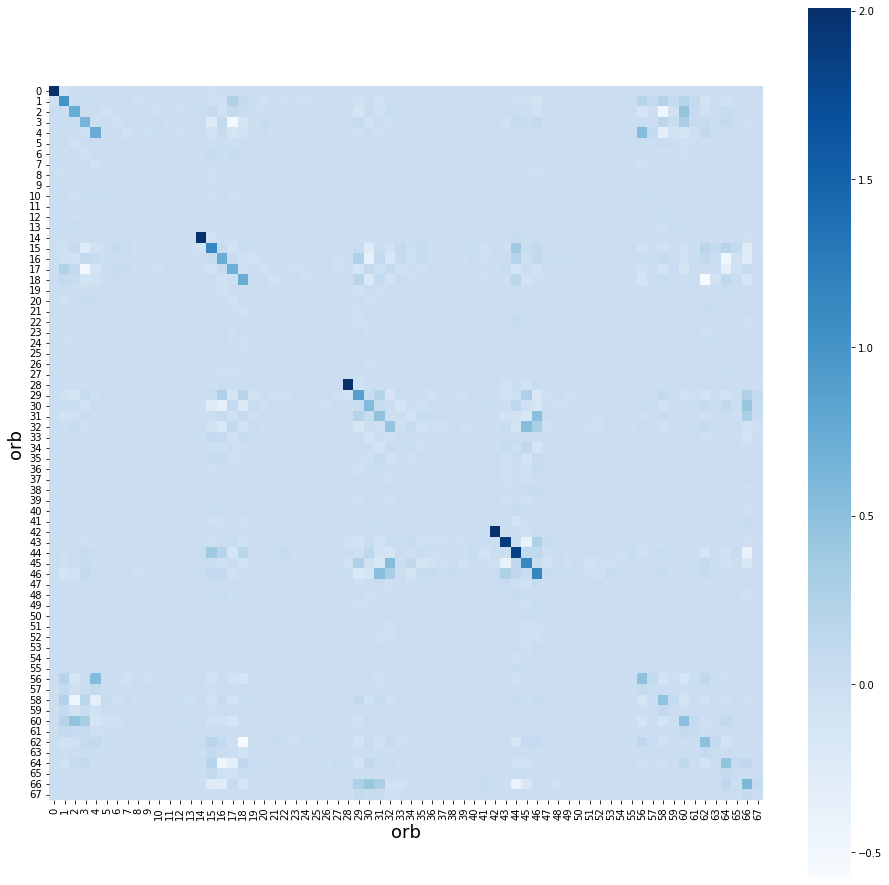

68 68 68


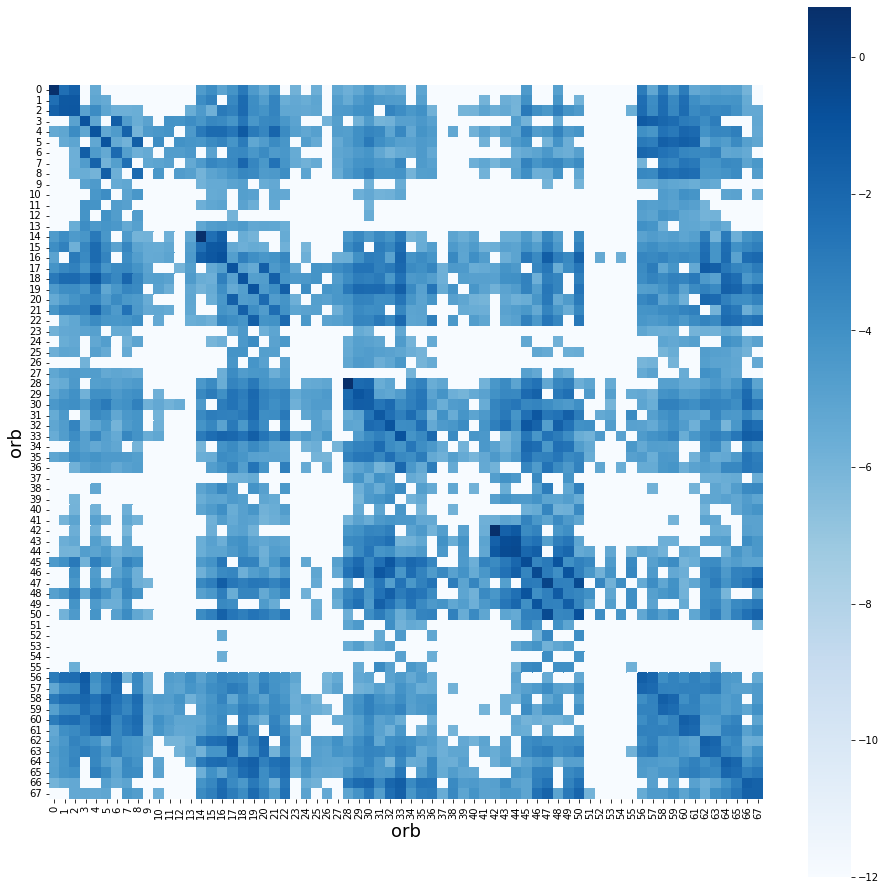

In [15]:
dm = chem_bond_analyzer.dm
dm_log = numpy.log(numpy.abs(dm))
Util_Pic.draw_heatmap(dm_mol_atom, None, None, numpy.max(
    dm_mol_atom), numpy.min(dm_mol_atom), x_label="orb", y_label="orb")
dm_log[dm_log<-6] = -12
Util_Pic.draw_heatmap(dm_log, None, None, numpy.max(
    dm_log), numpy.min(dm_log), x_label="orb", y_label="orb")

68 68 68


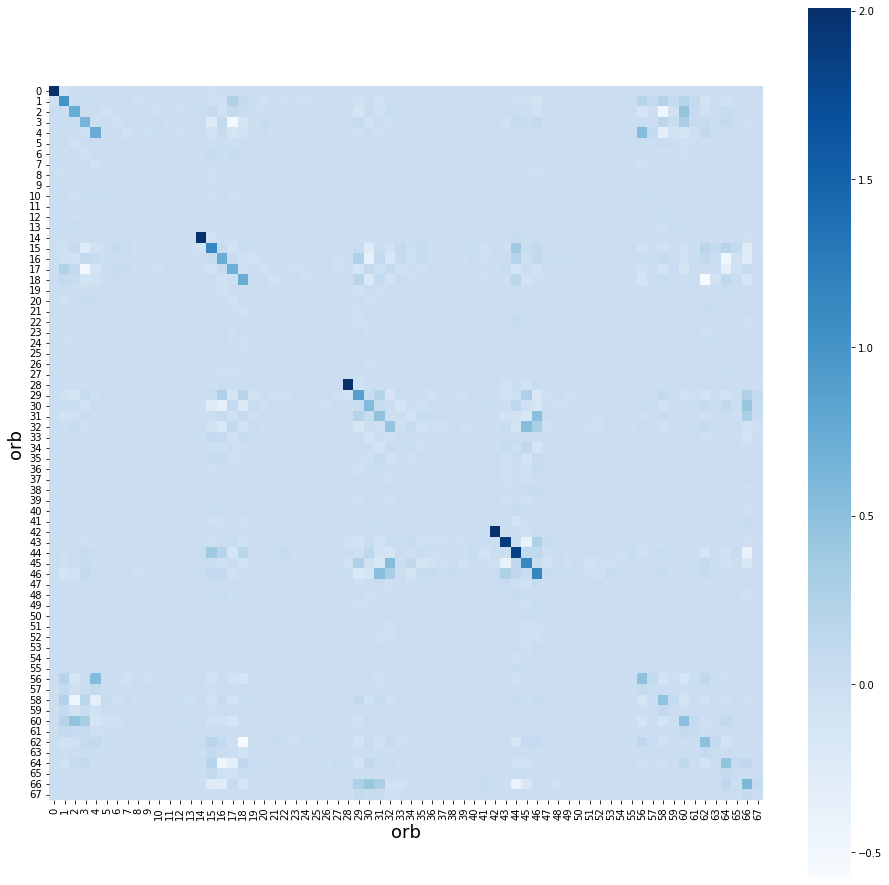

68 68 68


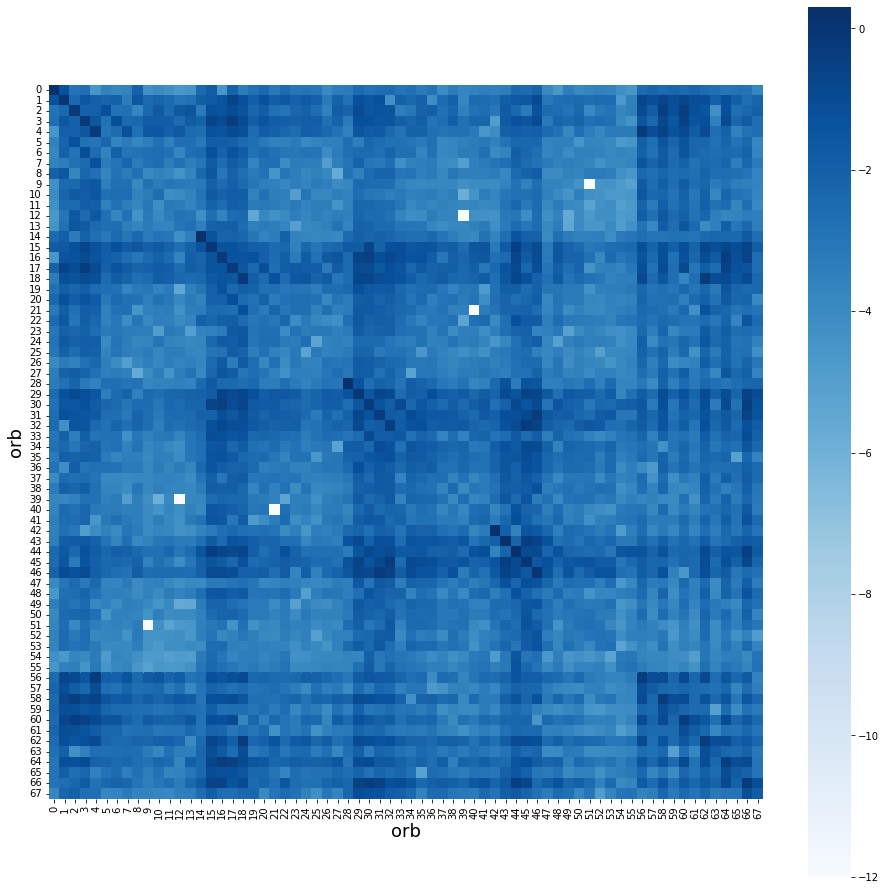

In [16]:
dm_mol_atom = chem_bond_analyzer.dm_mole_atom_bas
dm_mol_atom_log = numpy.log10(numpy.abs(dm_mol_atom))
dm_mol_atom_log[dm_mol_atom_log<-6] = -12
Util_Pic.draw_heatmap(dm_mol_atom, None, None, numpy.max(
    dm_mol_atom), numpy.min(dm_mol_atom), x_label="orb", y_label="orb")
Util_Pic.draw_heatmap(dm_mol_atom_log, None, None, numpy.max(
    dm_mol_atom_log), numpy.min(dm_mol_atom_log), x_label="orb", y_label="orb")

In [ ]:
Util_Pic.draw_heatmap(dm_mol_atom, None, None, numpy.max(
    dm_mol_atom), numpy.min(dm_mol_atom), x_label="orb", y_label="orb")


In [ ]:
Util_Pic.draw_heatmap(dm_mol_atom_log, None, None, numpy.max(
    dm_mol_atom_log), numpy.min(dm_mol_atom_log), x_label="orb", y_label="orb")


In [ ]:
# 35
mol, rohf, loc_orb, comp_orb = Chem_Bond_Analysis.analysis_mole_occ_orb('''
C 0.1687934049 1.5251304224 -0.1574705569
C -0.1873762459 0.0619476271 0.1467937419
C 0.5091764497 -0.4399621499 1.3912584954
O 1.1819107901 -1.4356558471 1.4581638410
H 1.2312651068 1.6313725408 -0.3963269270
H -0.4074466801 1.8943168107 -1.0096924649
H -0.0493103389 2.1726626043 0.6985743244
H -1.2690515996 -0.0166806666 0.3285443317
H 0.0627906152 -0.6025047855 -0.6847403572
H 0.3538484078 0.2066337038 2.2887105216
''', atom_bas=atom_bas, basis=basis, latex=False)

# 137
# analysis_mole_occ_orb('''
# C 0.0347806456 1.2913768586 0.1247459533
# O -0.0124513596 -0.1105695501 0.0035215127
# C -1.3281919535 -0.6320221466 -0.0127607421
# C -1.1967300713 -2.1468266455 0.0064786786
# O -0.5031446939 -2.5873432681 1.1564186604
# H 1.0873414096 1.5846828113 0.1391786759
# H -0.4608000759 1.7890668040 -0.7231438927
# H -0.4453207650 1.6365049394 1.0536386033
# H -1.8839981446 -0.2911083706 0.8759161059
# H -1.8749792357 -0.2956683369 -0.9096196771
# H -2.1909411142 -2.6051178926 0.0283531110
# H -0.6937741941 -2.4732100908 -0.9180616798
# H 0.2895967725 -2.0398442621 1.2052767005
# ''',basis="ccpvtz")

# 180
# analysis_mole_occ_orb('''
# C -0.0271346400 1.5221203086 0.0521305946
# C 0.0323693578 -0.0124749555 -0.0304120233
# C 0.7282693006 -0.5092869150 -1.2711077622
# C 0.1197239999 -0.2618318564 -2.6264349659
# N 1.8326439706 -1.1282801584 -1.0913424504
# O 2.4056288198 -1.5311268206 -2.3124791001
# H 0.9803323016 1.9481482522 0.0827491978
# H -0.5483940531 1.9540764861 -0.8082238646
# H -0.5580317568 1.8383921734 0.9549880432
# H 0.5562345897 -0.4149043749 0.8407760193
# H -0.9901253601 -0.4139258185 -0.0136576368
# H 0.7340383410 0.4356263481 -3.2064085046
# H 0.0848704736 -1.1928804821 -3.1995737774
# H -0.8885473976 0.1490816380 -2.5428579112
# H 3.1970636931 -1.9934940451 -2.0182152584
# ''',basis=basis)


In [ ]:
a = numpy.argsort(comp_orb[:,5])
print(comp_orb[:,5][a[-1]])
print(comp_orb[:,5][a[-2]])
print(comp_orb[:,5][a[-3]])

In [ ]:
# 146
_, _, _, _ = Chem_Bond_Analysis.analysis_mole_occ_orb('''
O -0.1067522688 0.2689337451 0.6057961106
C 0.1092672367 1.1676152927 -0.1749216340
C 1.2790736750 2.0782343341 -0.0588467453
C 1.4964489390 2.7013959092 1.2927537232
N 2.3836126925 1.6552095598 0.8154240580
H -0.5696452368 1.3625356471 -1.0315900759
H 1.5581001544 2.6326128995 -0.9500281947
H 1.9254436948 3.6980650620 1.3385645979
H 0.7690944710 2.4619330341 2.0635464902
H 2.1010635423 0.7682690363 1.2350124001
''', atom_bas=atom_bas, basis=basis, latex=False)


In [ ]:
# 199

# mol, rohf, loc_orb = analysis_mole_occ_orb('''
# O 0.1144614910 1.3501199050 0.2152030541
# C 0.0733291800 0.0129344505 0.0032687066
# C 0.0776309623 -0.8015496878 -1.0981976451
# N 0.0184319312 -2.1238248043 -0.6969565349
# C -0.0205120527 -2.1011226968 0.6089495301
# N 0.0108864053 -0.8149840425 1.0932893989
# H 0.1574570860 1.7926474026 -0.6379727847
# H 0.1191646930 -0.5214360219 -2.1394911247
# H -0.0709681805 -2.9568779431 1.2645592403
# H -0.0073527155 -0.5110280517 2.0524576694
# ''',basis="ccpvtz",latex=True)